<a href="https://colab.research.google.com/github/brettmlabo/embedded_skills_series_1/blob/master/DL_Proj_OLD_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro To Deep Learning Project
State classification for Robotic Cooking

---

## To use this program:
Run the code in the order stated and load in the dataset into your Drive under the path /content/drive/My Drive

In [ ]:
!pip install validators matplotlib
!pip install torchmetrics

In [ ]:
from torch.utils.data import Dataset
from google.colab import drive
from PIL import Image
from torchvision import transforms
import os

class FoodImageClassificationDataset(Dataset):
  def __init__(self, path):
    super().__init__()
    classes = os.listdir(path)
    classes.sort()
    self.data = []

    #Loads in all of the classes
    self.class_to_index = {}
    self.index_to_class = {}
    for i in range(len(classes)):
      self.class_to_index[classes[i]] = i
      self.index_to_class[i] = classes[i]
    print(self.class_to_index)

    #For each class, load in the images
    for class_name in classes:
      class_data = os.listdir(os.path.join(path, class_name))
      class_data = [os.path.join(path, class_name, img_name) for img_name in class_data]
      class_data = [(filepath, self.class_to_index[class_name]) for filepath in class_data]
      self.data += class_data

    #Initialize transform
    self.transform_to_tensor = transforms.ToTensor()
    self.transform_resize = transforms.CenterCrop((224, 224))
    self.transform_to_image = transforms.ToPILImage()

  def __getitem__(self, index):
     filepath, label = self.data[index] #Get the filepath and label
     img = Image.open(filepath)
     features = self.transform_to_tensor(img)
     features = self.transform_resize(features)
     return (features, label)

  def __len__(self):
    return len(self.data)

def load_dataset(self, path : str):
  '''Prepares the images in a folder such that they're in easily accessible key, value pairs'''

drive.mount('/content/drive')
train_dataset = FoodImageClassificationDataset("/content/drive/My Drive/state_dataset/train")
valid_dataset = FoodImageClassificationDataset("/content/drive/My Drive/state_dataset/valid")
print(f'Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Total: {len(train_dataset) + len(valid_dataset)}')
img = train_dataset[264]
print(img[0].shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'creamy_paste': 0, 'diced': 1, 'floured': 2, 'grated': 3, 'juiced': 4, 'jullienne': 5, 'mixed': 6, 'other': 7, 'peeled': 8, 'sliced': 9, 'whole': 10}
{'creamy_paste': 0, 'diced': 1, 'floured': 2, 'grated': 3, 'juiced': 4, 'jullienne': 5, 'mixed': 6, 'other': 7, 'peeled': 8, 'sliced': 9, 'whole': 10}
Train: 8583, Valid: 1912, Total: 10495
torch.Size([3, 224, 224])


In [ ]:
import torch
from torch import optim, nn
import random, time
from torch.utils.data import DataLoader

data_dir = 'data/hymenoptera_data' #Modify this path according to user's drive

class FoodImageClassifier(torch.nn.Module):
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  print(f'Using {device} for inference')

  def __init__(self):
    super().__init__()
    self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained = True)
    self.resnet50 = self.resnet50.to(FoodImageClassifier.device)

    #for param in self.resnet50.parameters():
      #param.requires_grad = False

    self.resnet50.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 11)).to(FoodImageClassifier.device)

  def forward(self, x):
    return torch.nn.functional.sigmoid(self.resnet50(x))

def train(model, dataloader, epochs = 15):
  model.train()
  optimizer = optim.SGD(model.parameters(), lr = 1e-2, momentum=0.9)

  for epoch in range(epochs):
    for batch in dataloader:
      features, labels = batch
      features = features.to(FoodImageClassifier.device)
      labels = labels.to(FoodImageClassifier.device)
      predictions = model(features).to(FoodImageClassifier.device) #Get the predictions
      #labels = labels.unsqueeze(1) #Modify the output so it's the correct size
      labels = labels.long() #ensure the labels are floats
      predictions = model(features) #Find the predictions
      loss = nn.functional.cross_entropy(predictions, labels) #Compute loss

      #Update weights
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      print(f'Loss: {loss.item()}')
    print(f'Epoch: {epoch}, Loss: {loss}')
    torch.save(classifier.state_dict(), 'trained_model.pth') # Changed 'model' to 'classifier'
    print("Model weights saved to 'trained_model.pth'")

def test(model, dataset, count):
    model.eval()
    total_correct = 0
    for i in range(count):
      with torch.no_grad():
        index = random.randint(0, len(dataset))
        input = dataset[index][0].unsqueeze(0).to(FoodImageClassifier.device)
        outputs = model(input).to(FoodImageClassifier.device)
        predictions = outputs.argmax(dim=1)
        display(dataset.transform_to_image(dataset[index][0]))
        print(f'Prediction: {dataset.index_to_class[(int)(predictions.item())]}, Label: {dataset.index_to_class[dataset[index][1]]}')
        total_correct += (sum(predictions == dataset[index][1])).item()
    print(f"Accuracy: {round(100 * total_correct / count, 2)} %")

def accuracy(model, dataset, dataloader):
    model.eval()
    size = len(dataset)
    total_correct = 0
    for batch in dataloader:
        features, labels = batch
        features = features.to(FoodImageClassifier.device)
        labels = labels.to(FoodImageClassifier.device)
        outputs = model(features)
        predictions = outputs.argmax(dim=1)
        total_correct += (sum(predictions == labels)).item()
        print(f'Correct this iter: {sum(predictions == labels).item()}, Running total: {total_correct}')
    print(f"Accuracy: {round(100 * total_correct / size, 2)} %")

Using cuda for inference


# Training Scripts

In [ ]:
#Train Script

classifier = FoodImageClassifier()
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
#accuracy(classifier, valid_dataset, valid_loader) #accuracy before training
train(classifier, train_loader)
accuracy(classifier, valid_dataset, valid_loader) #accuracy after training

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Loss: 2.3975846767425537
Loss: 2.4000601768493652
Loss: 2.3964030742645264
Loss: 2.398099899291992
Loss: 2.3989100456237793
Loss: 2.3980941772460938
Loss: 2.390125036239624
Loss: 2.3945770263671875
Loss: 2.4000704288482666
Loss: 2.390768527984619
Loss: 2.3950650691986084
Loss: 2.3971686363220215
Loss: 2.3936479091644287
Loss: 2.3963568210601807
Loss: 2.3866851329803467
Loss: 2.3844189643859863
Loss: 2.3934311866760254
Loss: 2.3845772743225098
Loss: 2.3835177421569824
Loss: 2.3861148357391357
Loss: 2.375561237335205
Loss: 2.3881335258483887
Loss: 2.3811333179473877
Loss: 2.3837273120880127
Loss: 2.3815696239471436
Loss: 2.3870294094085693
Loss: 2.3893778324127197
Loss: 2.380120038986206
Loss: 2.3843414783477783
Loss: 2.3708415031433105
Loss: 2.3831286430358887
Loss: 2.369533061981201
Loss: 2.3815062046051025
Loss: 2.374234914779663
Loss: 2.3701250553131104
Loss: 2.367030143737793
Loss: 2.3530938625335693
Loss: 2.3657679557800293
Loss: 2.3608579635620117
Loss: 2.3567023277282715
Loss: 2.

In [ ]:
torch.save(classifier.state_dict(), 'trained_model.pth') # Changed 'model' to 'classifier'
print("Model weights saved to 'trained_model.pth'")



Model weights saved to 'trained_model.pth'


In [ ]:
# load saved weights
classifier.load_state_dict(torch.load('trained_model.pth')) #Changed 'model' to 'classifier'
classifier.eval()  # Set the model to evaluation mode

# Testing Scripts

In [ ]:
#Initialize validation dataset
classifier = FoodImageClassifier()
valid_dataset = FoodImageClassificationDataset("/content/drive/My Drive/state_dataset/valid")
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
classifier.load_state_dict(torch.load('trained_model.pth')) #Changed 'model' to 'classifier'

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


{'creamy_paste': 0, 'diced': 1, 'floured': 2, 'grated': 3, 'juiced': 4, 'jullienne': 5, 'mixed': 6, 'other': 7, 'peeled': 8, 'sliced': 9, 'whole': 10}


<All keys matched successfully>

In [ ]:
# Test the model on the entire validation dataset
accuracy(classifier, valid_dataset, valid_loader)

Correct this iter: 29, Running total: 29
Correct this iter: 24, Running total: 53
Correct this iter: 28, Running total: 81
Correct this iter: 23, Running total: 104
Correct this iter: 26, Running total: 130
Correct this iter: 29, Running total: 159
Correct this iter: 28, Running total: 187
Correct this iter: 30, Running total: 217
Correct this iter: 22, Running total: 239
Correct this iter: 26, Running total: 265
Correct this iter: 25, Running total: 290
Correct this iter: 23, Running total: 313
Correct this iter: 22, Running total: 335
Correct this iter: 23, Running total: 358
Correct this iter: 27, Running total: 385
Correct this iter: 25, Running total: 410
Correct this iter: 27, Running total: 437
Correct this iter: 19, Running total: 456
Correct this iter: 26, Running total: 482
Correct this iter: 24, Running total: 506
Correct this iter: 26, Running total: 532
Correct this iter: 26, Running total: 558
Correct this iter: 24, Running total: 582
Correct this iter: 27, Running total:

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


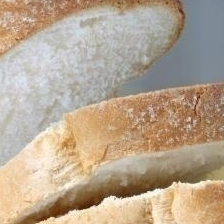

Prediction: sliced, Label: sliced


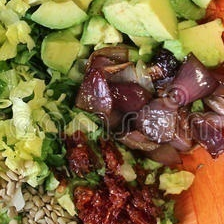

Prediction: mixed, Label: other


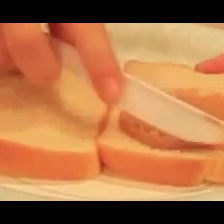

Prediction: sliced, Label: sliced


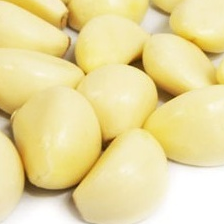

Prediction: peeled, Label: peeled


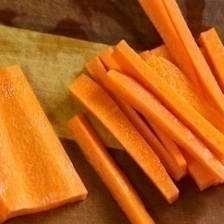

Prediction: jullienne, Label: jullienne


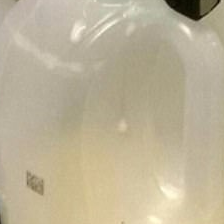

Prediction: juiced, Label: juiced


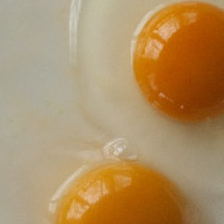

Prediction: juiced, Label: other


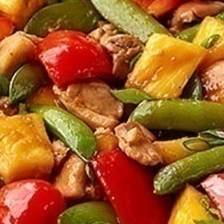

Prediction: mixed, Label: mixed


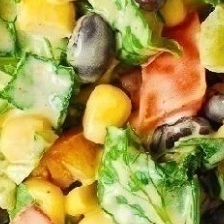

Prediction: mixed, Label: mixed


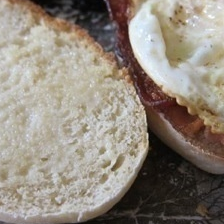

Prediction: other, Label: other
Accuracy: 80.0 %


In [ ]:
#This was only giving 0 or 10% accuracy

# Test the model on a small sample
#classifier = FoodImageClassifier()
#valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
#classifier.load_state_dict(torch.load('trained_model.pth')) #Changed 'model' to 'classifier'

#test(FoodImageClassifier(), valid_dataset, 10)

#This correction gives 80% accuracy
# Initialize classifier and load the trained model weights
classifier = FoodImageClassifier()
classifier.load_state_dict(torch.load('trained_model.pth'))  # Load trained model weights
classifier.to(FoodImageClassifier.device)  # Move the model to the appropriate device (cuda or cpu)

# Now use the same classifier to test the model
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test(classifier, valid_dataset, 10)  # Pass the classifier with the loaded weights

Improvements

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

# Data preprocessing, cleaning, transformation and augmentation combined
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Data preprocessing: resize images to a consistent size
    # transforms.RandomHorizontalFlip(),  # Data augmentation: randomly flip images horizontally
    # transforms.RandomRotation(15),  # Data augmentation: randomly rotate images
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Data augmentation: apply brightness, contrast, and saturation changes
    transforms.CenterCrop(224),  # Data transformation: crop to center square
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Data transformation: normalize pixel values
])

valid_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
data_dir = '/content/drive/My Drive/state_dataset'
train_dataset = datasets.ImageFolder(f'{data_dir}/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder(f'{data_dir}/valid', transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Model definition with Dropout, BatchNorm, and Residual connections included
class ImprovedFoodClassifier(nn.Module):
    def __init__(self, num_classes=11):
        super(ImprovedFoodClassifier, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False  # Freeze pretrained layers

        self.base_model.fc = nn.Sequential(
            nn.Linear(2048, 256),
            # nn.BatchNorm1d(256),  # Batch normalization: normalize layer activations
            nn.ReLU(inplace=True),
            # nn.Dropout(p=0.5),  # Dropout: randomly drop units to prevent overfitting
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Training loop
def train_model(model, criterion, optimizer, dataloaders, device, epochs=10):
    model = model.to(device)
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        model.train()

        running_loss = 0.0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(dataloaders['train'])
        print(f'Training Loss: {epoch_loss:.4f}')

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

# Instantiate and run the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedFoodClassifier()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.base_model.fc.parameters(), lr=learning_rate)

dataloaders = {'train': train_loader, 'valid': valid_loader}

train_model(model, criterion, optimizer, dataloaders, device)
evaluate_model(model, valid_loader, device)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/state_dataset/train'